In [16]:
#!pip install video-indexer
#!pip install Pillow==8.4
#!pip install azure-cognitiveservices-vision-computervision
#!pip install pip install azure-cognitiveservices-vision-customvision
#!pip install pip install cognitive-face
#!pip install pip install azure-cognitiveservices-vision-face

In [24]:
import io
import datetime
import pandas as pd
from PIL import Image
import requests
import io
import glob, os, sys, time, uuid

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw

from video_indexer import VideoIndexer
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials
from dotenv import load_dotenv
import os
load_dotenv()

True

In [25]:

CONFIG = {
    'SUBSCRIPTION_KEY': os.getenv("SUBSCRIPTION_KEY"),
    'LOCATION': 'trial',
    'ACCOUNT_ID': os.getenv("ACCOUNT_ID"), 
    'FACIAL_RECOGNITION_ENDPOINT': os.getenv('AZURE_FACIAL_RECOGNIZER_ENDPOINT'), 
    'FACIAL_RECOGNITION_KEY': os.getenv('AZURE_FACIAL_RECOGNIZER_KEY'), 
    'FORM_RECOGNITION_ENDPOINT': os.getenv('AZURE_FORM_RECOGNIZER_ENDPOINT'), 
    'FORM_RECOGNITION_KEY': os.getenv('AZURE_FORM_RECOGNIZER_KEY')
}

video_analysis = VideoIndexer(
    vi_location=CONFIG['LOCATION'],
    vi_account_id=CONFIG['ACCOUNT_ID'], 
    vi_subscription_key=CONFIG['SUBSCRIPTION_KEY']
)

In [3]:
#video_analysis.check_access_token() 8757428808

In [ ]:
# Upload to Video Analzyer from local disk
uploaded_video_id = video_analysis.upload_to_video_indexer(
   input_filename='/home/workspace/video-indexer-demo-video.mp4',
   video_name='avkash-11-second',  # unique identifier for video in Video Indexer platform
   video_language='English'
)
info = video_analysis.get_video_info(uploaded_video_id, video_language='English')

In [4]:
video_id = '8757428808'

In [15]:
info = video_analysis.get_video_info(video_id, video_language='English')

Getting video info for: 8757428808


In [6]:
if len(info['videos'][0]['insights']['faces'][0]['thumbnails']):
    print("We found {} faces in this video.".format(str(len(info['videos'][0]['insights']['faces'][0]['thumbnails']))))

We found 6 faces in this video.


In [10]:
images = []
img_raw = []
img_strs = []
thumbnails = []
for each_thumb in info['videos'][0]['insights']['faces'][0]['thumbnails']:
    if 'fileName' in each_thumb and 'id' in each_thumb:
        file_name = each_thumb['fileName']
        thumb_id = each_thumb['id']
        img_code = video_analysis.get_thumbnail_from_video_indexer(video_id,  thumb_id)
        img_strs.append(img_code)
        img_stream = io.BytesIO(img_code)
        img_raw.append(img_stream)
        img = Image.open(img_stream)
        images.append(img)
        thumbnails.append(thumb_id)

Getting thumbnail from video: 8757428808, thumbnail: 55d785fc-652d-46b8-a62c-fd9b2baad4b1
Getting thumbnail from video: 8757428808, thumbnail: 5d93065f-cb5a-4917-b14a-a87fd558d4ea
Getting thumbnail from video: 8757428808, thumbnail: 18aa87b1-b9a0-497b-84f9-6cf034bdf2f8
Getting thumbnail from video: 8757428808, thumbnail: 77dffdf1-9a9c-42a0-9bb0-8ff3feef80c1
Getting thumbnail from video: 8757428808, thumbnail: 99b09277-aa96-4470-9d95-6d01e4fb642e
Getting thumbnail from video: 8757428808, thumbnail: 87854f5a-baf3-434f-a852-c0eb728ca557


{'comment': b'Lavc58.54.100\x00'}
{'comment': b'Lavc58.54.100\x00'}
{'comment': b'Lavc58.54.100\x00'}
{'comment': b'Lavc58.54.100\x00'}
{'comment': b'Lavc58.54.100\x00'}
{'comment': b'Lavc58.54.100\x00'}


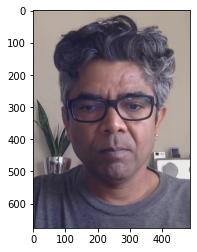

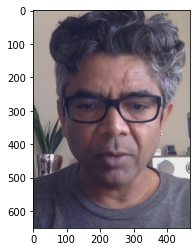

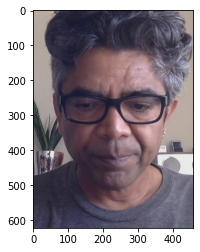

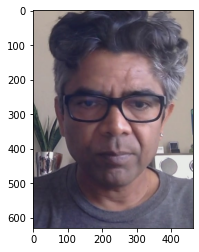

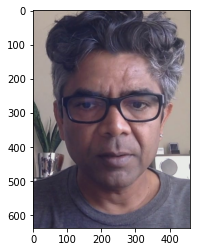

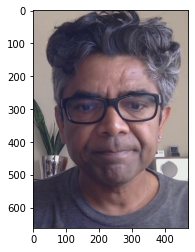

In [8]:
for img in images:
    print(img.info)
    plt.figure()
    plt.imshow(img)

In [53]:
thumbnail_directory = "./data/ai-generated-thumbnails/"
i = 1
for img in images:
    img.save(thumbnail_directory + 'human-face' + str(i) + '.jpg')
    i= i+ 1
print("Thumbnails saved to {}".format(thumbnail_directory))

Thumbnails saved to ./data/ai-generated-thumbnails/


In [13]:
img_code = video_analysis.get_thumbnail_from_video_indexer(video_id,  thumbnails[0])

Getting thumbnail from video: 8757428808, thumbnail: 55d785fc-652d-46b8-a62c-fd9b2baad4b1


In [22]:
#info = video_analysis.get_video_info(video_id, video_language='English')
info['summarizedInsights']['sentiments']
info['summarizedInsights']['emotions']

[]

### Person Model using Video Images

In [ ]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'avkash'
face_client = FaceClient(AVKASH_FACE_ENDPOINT, CognitiveServicesCredentials(AVKASH_FACE_KEY))

In [ ]:
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    client.person_group.create(person_group_id = person_group_id, name=person_group_id)

    # Create a person group person.
    human_person = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg human images in working directory.
    human_face_images = [file for file in glob.glob('*.jpg') if file.startswith("human-face")]
    # Add images to a Person object
    for image_p in human_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, human_person.person_id, w)

    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

In [ ]:
def detect_faces(client, query_images_list):
    print('Detecting faces in query images list...')

    face_ids = {} # Keep track of the image ID and the related image in a dictionary
    for image_name in query_images_list:
        image = open(image_name, 'rb') # BufferedReader
        print("Opening image: ", image.name)
        time.sleep(5)

        # Detect the faces in the query images list one at a time, returns list[DetectedFace]
        faces = client.face.detect_with_stream(image)  

        # Add all detected face IDs to a list
        for face in faces:
            print('Face ID', face.face_id, 'found in image', os.path.splitext(image.name)[0]+'.jpg')
            # Add the ID to a dictionary with image name as a key.
            # This assumes there is only one face per image (since you can't have duplicate keys)
            face_ids[image.name] = face.face_id

    return face_ids

In [ ]:
test_images = [file for file in glob.glob('*.jpg') if file.startswith("human-face")]
test_images

In [ ]:
ids = detect_faces(face_client, test_images)
ids

In [ ]:
verify_result = face_client.face.verify_face_to_face(ids['human-face1.jpg'], ids['human-face2.jpg'])
if verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

In [ ]:
for face in dl_faces:
    print('Face ID', face.face_id, 'found in image', dl_source_url)
    # Add the ID to a dictionary with image name as a key.
    # This assumes there is only one face per image (since you can't have duplicate keys)
    ids['ca-dl-sample.png'] = face.face_id

In [ ]:
dl_verify_result = face_client.face.verify_face_to_face(ids['human-face4.jpg'], ids['ca-dl-sample.png'])
if dl_verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(dl_verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(dl_verify_result.confidence))

In [ ]:
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

In [ ]:
def drawFaceRectangles(source_file, detected_face_object) :
    # Download the image from the url
    response = requests.get(source_file)
    img = Image.open(BytesIO(response.content))
    # Draw a red box around every detected faces
    draw = ImageDraw.Draw(img)
    for face in detected_face_object:
        draw.rectangle(getRectangle(face), outline='red', width = 10)
    return img

In [ ]:
drawFaceRectangles(dl_source_url, dl_faces)

In [ ]:
get_the_face_id_from_the_driving_license = 'ENTER FACE ID HERE'
person_gp_results = face_client.face.identify([get_the_face_id_from_the_driving_license], PERSON_GROUP_ID)
for result in person_gp_results:
    for candidate in result.candidates:
        print("The Identity match confidence is {}".format(candidate.confidence))

### Extract Face from Digital ID

In [ ]:
face_client = FaceClient(CONFIG['FACIAL_RECOGNITION_ENDPOINT'], CognitiveServicesCredentials(CONFIG['FACIAL_RECOGNITION_KEY']))
image_url = ''

In [ ]:
def detect_face_with_attributes_02_from_any_url(selected_image_url):
    detected_faces = face_client.face.detect_with_url(url=selected_image_url, 
                                                     return_face_attributes=[
                    'age',
                    'gender',
                    'headPose',
                    'smile',
                    'facialHair',
                    'glasses',
                    'emotion',
                    'hair',
                    'makeup',
                    'occlusion',
                    'accessories',
                    'blur',
                    'exposure',
                    'noise'
                ])
    if not detected_faces:
        raise Exception('No face detected from image {}'.format(selected_image_url))        
    print('Total face(s) detected  from {}'.format(str(len(detected_faces))))
    return detected_faces

In [ ]:
detected_faces_01_object = detect_face_with_attributes_02_from_any_url(image_01)

In [ ]:
def detect_face_from_any_url(selected_image):
    detected_faces = face_client.face.detect_with_url(url=selected_image, detection_model='detection_03')
    if not detected_faces:
        raise Exception('No face detected from image {}'.format(single_image_name))        
    print('Total face(s) detected  from {}'.format(str(len(detected_faces))))
    return detected_faces

In [ ]:
def list_all_faces_from_detected_face_object(detected_faces_object):
    print('We found total {} face(s) in selected face detected object.'.format(str(len(detected_faces_object))))
    for face in detected_faces_object: 
        print (face.face_id)

In [ ]:
source_faces_object = detect_face_from_any_url(face_image)
list_all_faces_from_detected_face_object(source_faces_object)
drawFaceRectangles(group_image, group_faces_object)

### Final Verification between Digital ID and Video Analyzer Image


In [ ]:
verify_result_same = face_client.face.verify_face_to_face(source_image_face_id, similar_face.face_id)
print('Faces from {} & {} are of the same person, with confidence: {}'.format(face_image, group_image, verify_result_same.confidence))
if verify_result_same.is_identical:
      print("Faces are Similar")
else:
      print('Faces from {} & {} are of a different person, with confidence: {}'.format(face_image, group_image, verify_result_same.confidence))